# Genesis4 Particles

This shows examples of the various ways to input particle data into Genesis4.

In [1]:
from genesis.version4 import Genesis4
from lume.tools import full_path
import os
import numpy as np
from scipy.constants import c
from math import sqrt, pi
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Lattice

Create a simple drift lattice

In [2]:
LATFILE = 'data/genesis4_drift.lat'

def make_lat():
    lat = f"""
D1: DRIFT = {{ l = 1}};
LAT: LINE= {{ D1 }};
    """
    with open(LATFILE, 'w') as f:
        f.write(lat)
    
make_lat()
!cat {LATFILE}


D1: DRIFT = { l = 1};
LAT: LINE= { D1 };
    

# `profile_gauss`

This profile will make a Gaussian distribition. Here we do some calculations to make the correct bunch length for a given bunch charge to provide a peak current.

In [3]:
PEAK_CURRENT = 1000
BUNCH_CHARGE = 100e-12
SIGMA_T = BUNCH_CHARGE / (sqrt(2*pi) * PEAK_CURRENT)
SIGMA_Z = SIGMA_T * c
SLEN = 6*SIGMA_Z
S0 = 3*SIGMA_Z
SIGMA_T, SIGMA_Z, SLEN

(3.989422804014327e-14, 1.1959988684167075e-05, 7.175993210500245e-05)

In [4]:
G = Genesis4()

INPUT0 = {'main': [{'type': 'setup',
   'rootname': 'drift_test',
   'lattice': full_path(LATFILE),
   'beamline': 'LAT',
   'lambda0': 100e-9,
   'gamma0': 1000,
   'delz': 0.026,
   'seed': 123456,
   'npart': 128},
  {'type': 'time', 'slen': SLEN, 'sample': 1},
  {'type': 'profile_gauss',
   'label': 'beamcurrent',
   'c0': PEAK_CURRENT,
   's0': S0,
   'sig': SIGMA_Z},
  {'type': 'beam',
   'current': '@beamcurrent',
   'gamma': 1000,
   'delgam': 1,
  },
  {'type': 'track', 'zstop': 1},
  {'type':'write', 'beam':'end'},
                  ]}

G.input = INPUT0
G.verbose=True
G.run()

Configured to run in: /var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmpkls16j83
Running Genesis4 in /var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmpkls16j83
/Users/cmayes/miniconda3/envs/genesis-dev/bin/genesis4 genesis4.in
---------------------------------------------
GENESIS - Version 4.6.4 has started...
Compile info: Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: 
Starting Time: Thu Jan  4 11:04:10 2024

MPI-Comm Size: 1 node

Parsing lattice file...
Setting up time window of 71.8 microns with 718 sample points...
Adding profile with label: beamcurrent
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 718 slices for a time window of 71.8 microns
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
Writing output file...

Core Simulation done.
Diagnostic::~Diagnostic()
End of Track
Writing particle distribution to file: end.par.h5 ...

Program is terminating...
Ending Time: Thu Jan  4 

Loaded particle data: 'end' as a ParticleGroup with 91904 particles


<ParticleGroup with 91904 particles at 0x137bb18e0>

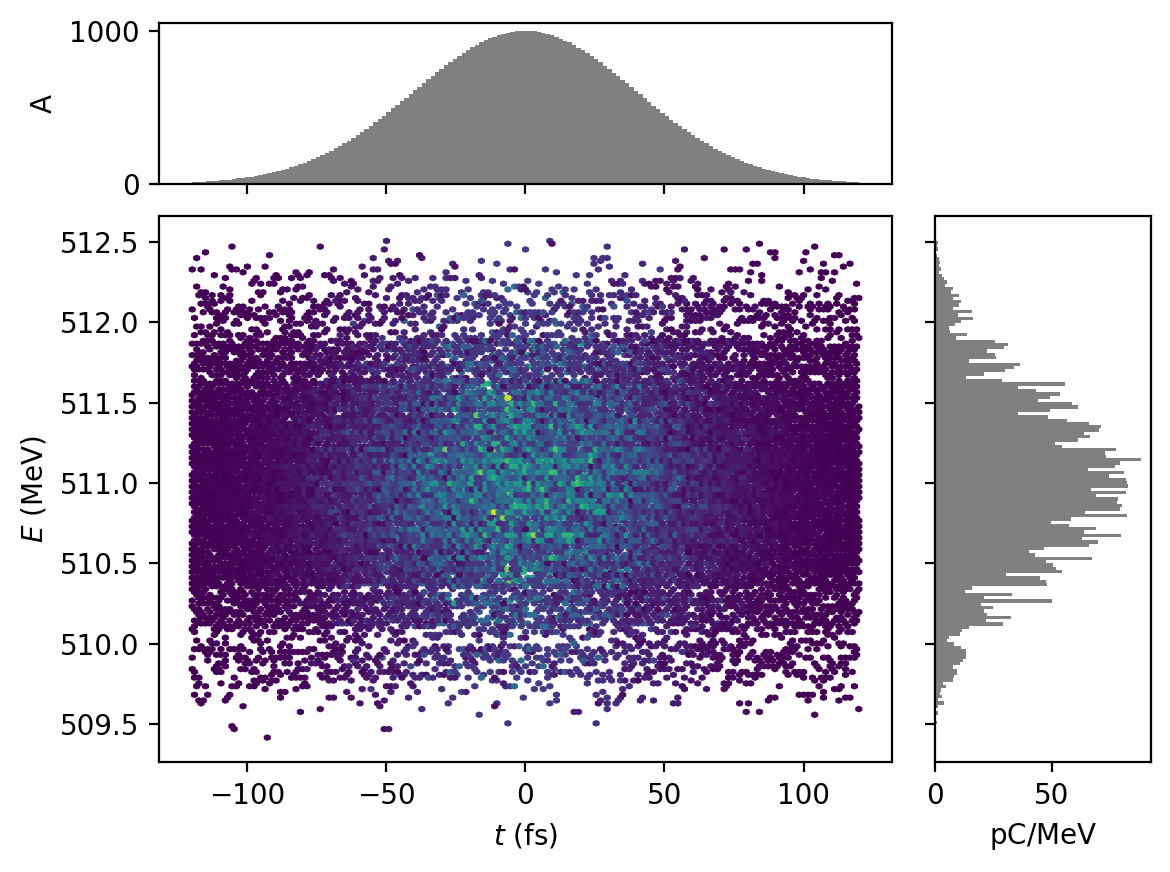

In [5]:
G.load_particles()
P1 = G.particles['end']
P1.drift_to_z()
P1.plot('t', 'energy')
P1

Check the charge

In [6]:
P1.charge

9.973150081144012e-11

# `profile_file`

LUME-Genesis automatically makes an HDF5 file from the arrays in the `profile_file` namelist. The user just needs to provide these in the dict in place of the filename. 

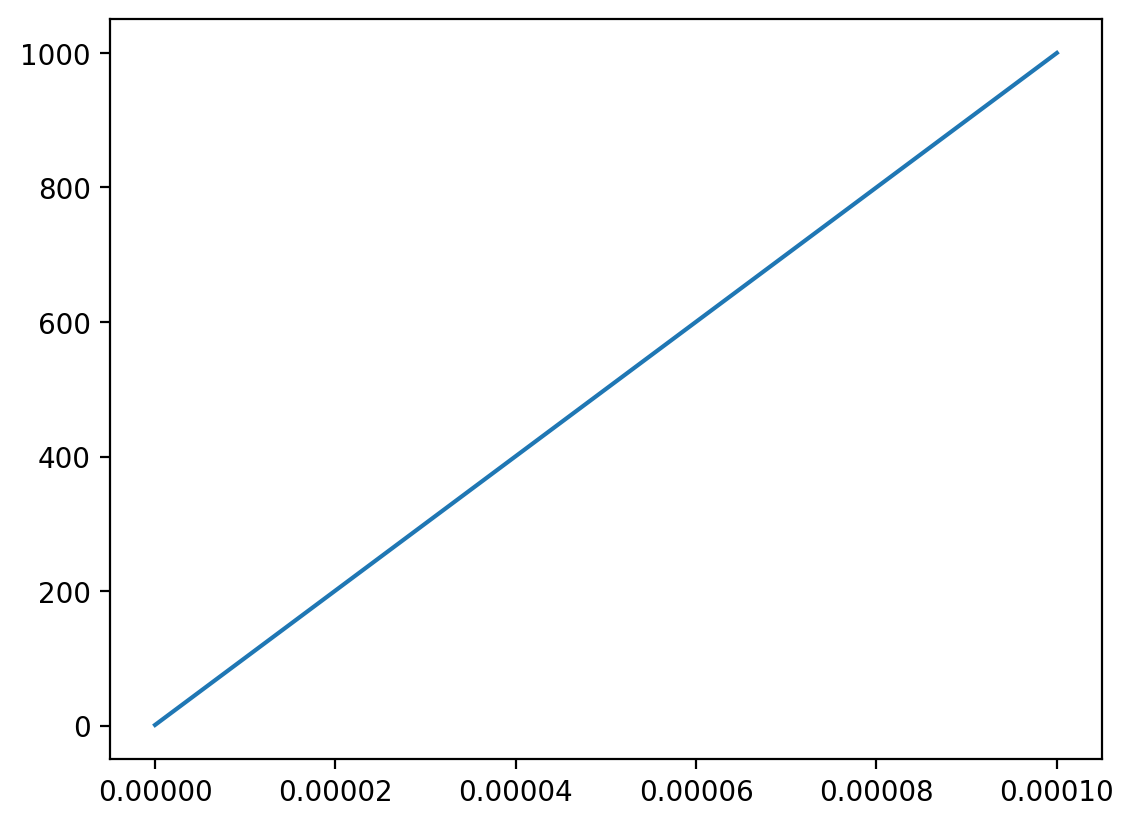

In [7]:
NPTS = 100
SLEN = 100e-6 
S = np.linspace(0, SLEN, NPTS)
CURRENT = np.linspace(1, 1000.0, NPTS)
plt.plot(S, CURRENT)

In [8]:
G = Genesis4()

INPUT0 = {'main': [{'type': 'setup',
   'rootname': 'drift_test',
   'lattice': full_path(LATFILE),
   'beamline': 'LAT',
   'lambda0': 100e-9,
   'gamma0': 1000,
   'delz': 0.026,
   'seed': 123456,
   'npart': 128},
  {'type': 'time', 'slen': SLEN, 'sample': 1},
 # {'type': 'field', 'dgrid': 0.0001, 'ngrid': 101, 'accumulate': True},
  {'type': 'profile_file',
   'label': 'beamcurrent',
   'xdata': S, 
   'ydata': CURRENT},
  {'type': 'beam',
   'current': '@beamcurrent',
   'gamma': 1000,
   'delgam': 1,
   'ex': 1e-6,
   'ey': 1e-6,
   'alphax': -0.7393217413918415,
   'betax': 7.910909406464387,
   'alphay': 1.3870723536888105,
   'betay': 16.881178621346898},
  {'type': 'track', 'zstop': 1},
  {'type':'write', 'beam':'end'},
                  ]}

G.input = INPUT0
G.verbose=True
G.run()

Configured to run in: /var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmpqawh8_u3
Running Genesis4 in /var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmpqawh8_u3
/Users/cmayes/miniconda3/envs/genesis-dev/bin/genesis4 genesis4.in
---------------------------------------------
GENESIS - Version 4.6.4 has started...
Compile info: Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: 
Starting Time: Thu Jan  4 11:04:12 2024

MPI-Comm Size: 1 node

Parsing lattice file...
Setting up time window of 100 microns with 1000 sample points...
Adding profile with label: beamcurrent
Generating input particle distribution...

Running Core Simulation...
Time-dependent run with 1000 slices for a time window of 100 microns
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
Writing output file...

Core Simulation done.
Diagnostic::~Diagnostic()
End of Track
Writing particle distribution to file: end.par.h5 ...

Program is terminating...
Ending Time: Thu Jan  4 

Loaded particle data: 'end' as a ParticleGroup with 128000 particles


<ParticleGroup with 128000 particles at 0x137d2f830>

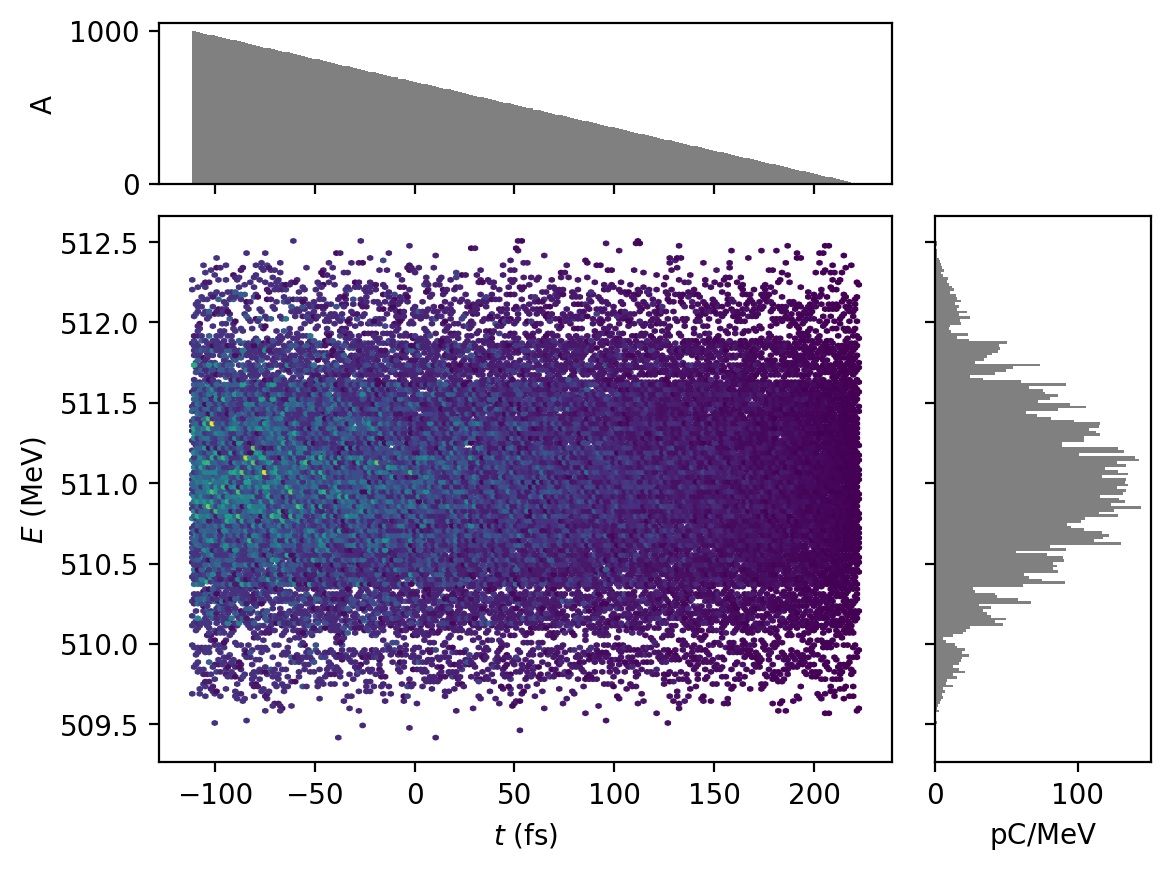

In [9]:
G.load_particles()
P1 = G.particles['end']
P1.drift_to_z()
P1.plot('t', 'energy')
P1

Resample particles for equal weights. This is neccessary when reading from a distribution file.

<ParticleGroup with 128000 particles at 0x1603f9b20>

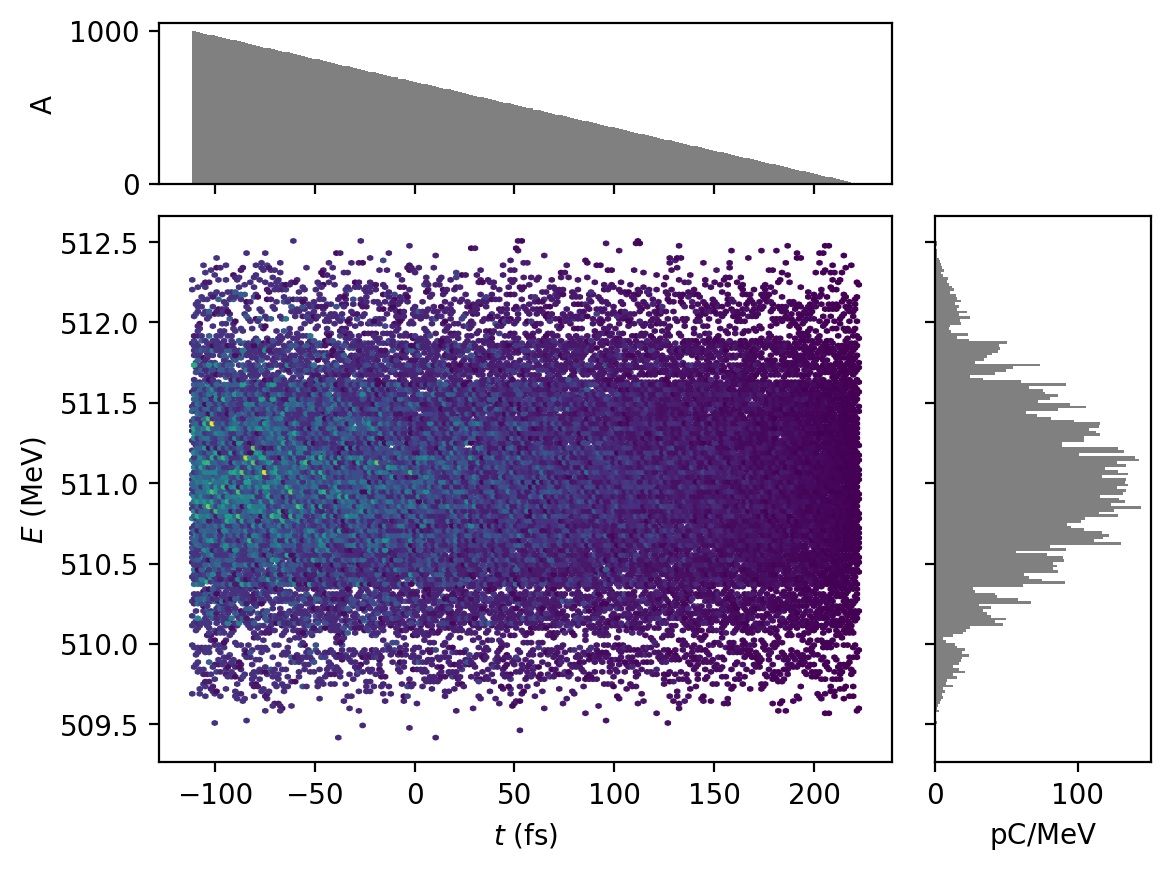

In [10]:
NSAMPLE = len(P1)
P1r = P1.resample(NSAMPLE)
P1r.plot('t', 'energy')
P1r

Make a more interesting distribution from this:

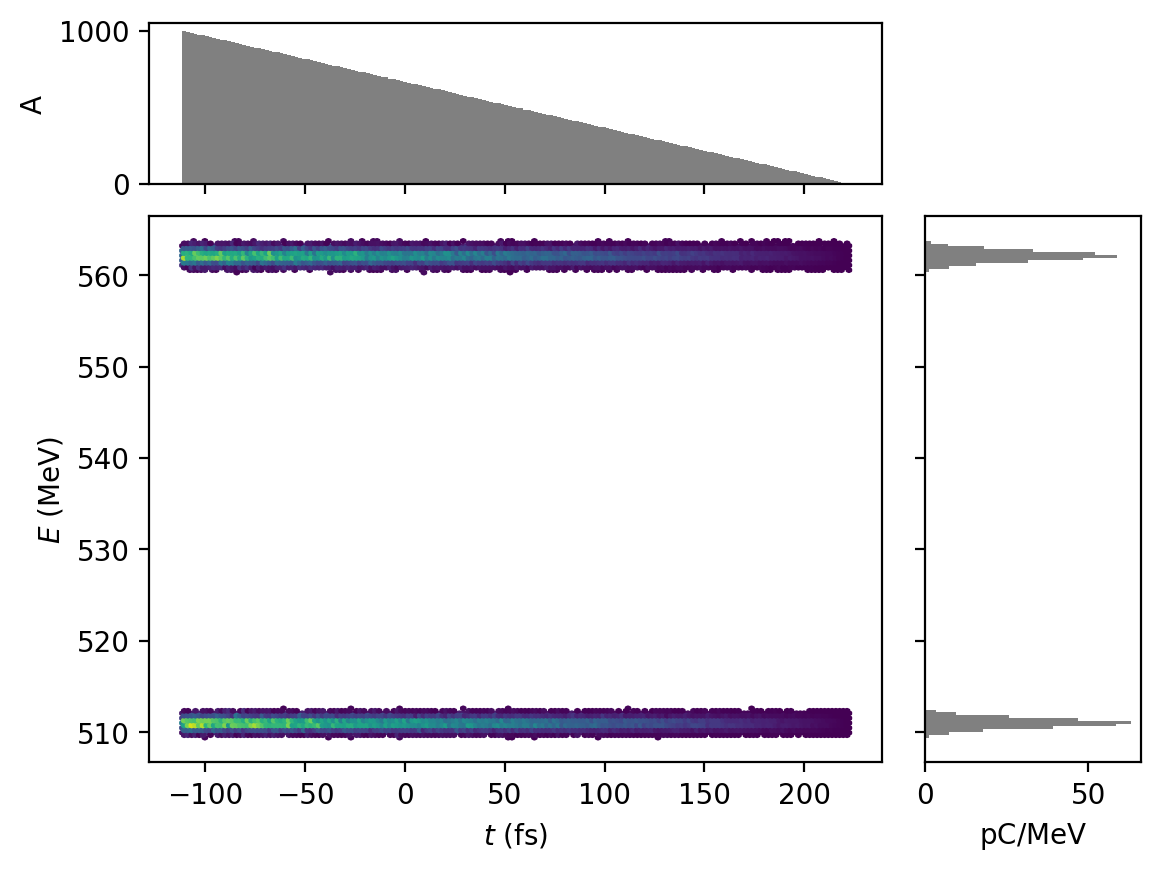

In [11]:
P1r.pz[0:len(P1)//2] *= 1.1
P1r.plot('t', 'energy')

ParticleGroup can write to a file for Genesis4.

In [12]:
DIST_FILE = 'genesis4_distribution.h5'
P1r.write_genesis4_distribution(DIST_FILE, verbose=True)

Resampling 128000 weighted particles
Datasets x, xp, y, yp, t, p written to: genesis4_distribution.h5


# importdistribution

Use this file as the input to a new simulation. 

When using `.initial_particles`, the appropriate input will be written automatically. 

In [13]:
G1 = Genesis4()

INPUT1 = {'main': [{'type': 'setup',
   'rootname': 'drift_test',
   'lattice': full_path(LATFILE),
   'beamline': 'LAT',
   'lambda0': 100e-9,
   'gamma0': 1000,
   'delz': 0.026,
   'seed': 123456,
   'npart': 128*4},
  {'type': 'time', 'slen': SLEN, 'sample': 1},
#  {'type': 'field', 'dgrid': 0.0001, 'ngrid': 101, 'accumulate': True},
  {'type': 'track', 'zstop': 1},
  {'type':'write', 'beam':'end'},
                  ]}

G1.input = INPUT1
G1.verbose=True
G1.initial_particles = P1r
G1.run()

Configured to run in: /var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmptadbud1w
Running Genesis4 in /var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmptadbud1w
/Users/cmayes/miniconda3/envs/genesis-dev/bin/genesis4 genesis4.in
Initial particles written to /var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmptadbud1w/genesis4_importdistribution.h5
Updated slen = 9.999850899316347e-05
Added new importdistribution before the first track
---------------------------------------------
GENESIS - Version 4.6.4 has started...
Compile info: Compiled by runner at 2023-12-16 00:59:36 [UTC] from Git Commit ID: 
Starting Time: Thu Jan  4 11:04:29 2024

MPI-Comm Size: 1 node

Parsing lattice file...
Setting up time window of 100 microns with 1000 sample points...
Importing distribution file... 
Charge of external distribution: 1.66782e-10
Particles in external distribution: 128000
Analysing external distribution... 
Analysis of the imported distribution
   Total Bunch Length  (microns): 99.6754
  


Program is terminating...
Ending Time: Thu Jan  4 07:13:51 2024
Total Wall Clock Time: 0.43379 seconds
-------------------------------------
Finished.
Loading main output: /var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmp52csyiz3/drift_test.out.h5


In [14]:
G1.load_particles()
P2 = G1.particles['end']
P2.z

Loaded particle data: 'end' as a ParticleGroup with 512000 particles


array([9.80962572e-09, 3.77892085e-08, 6.94265245e-08, ...,
       9.99384945e-05, 9.99631953e-05, 9.99883580e-05])

<ParticleGroup with 512000 particles at 0x160257560>

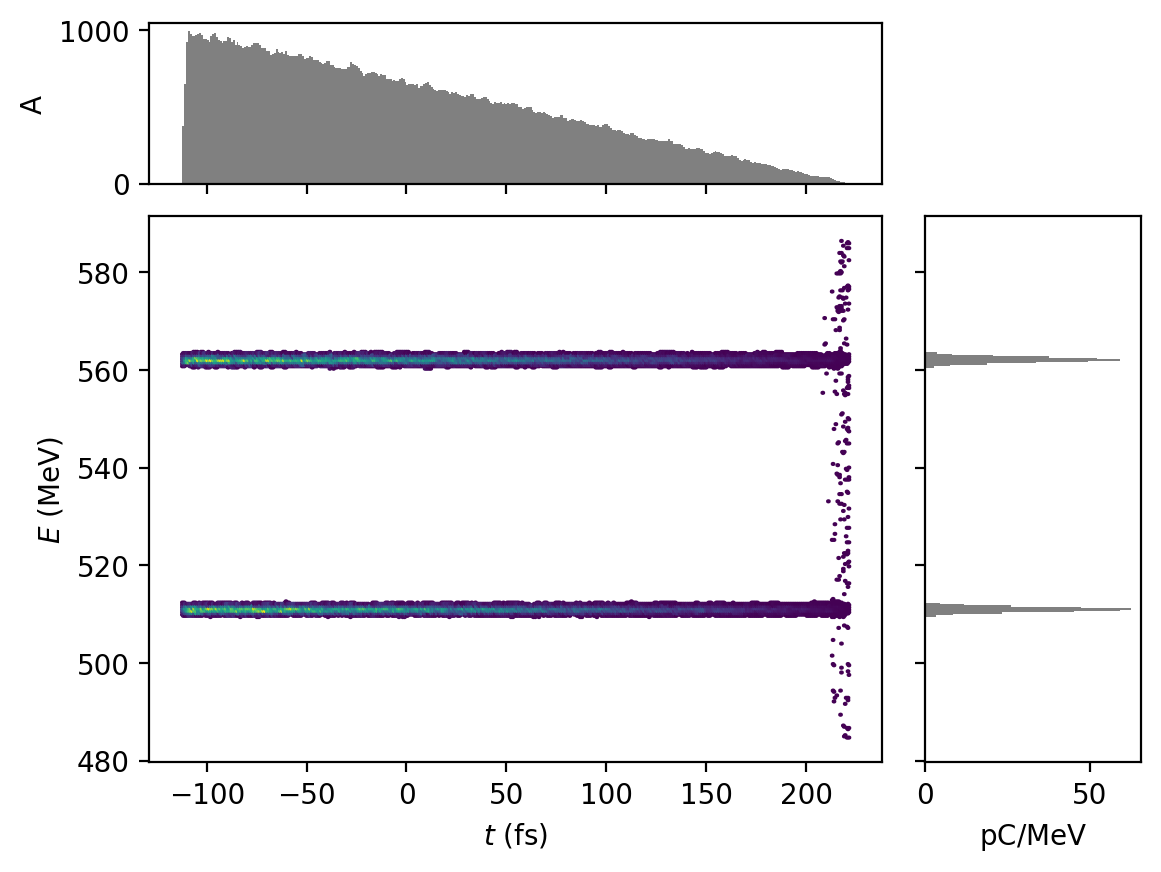

In [15]:
P2.drift_to_z()
P2.plot('t', 'energy')
P2

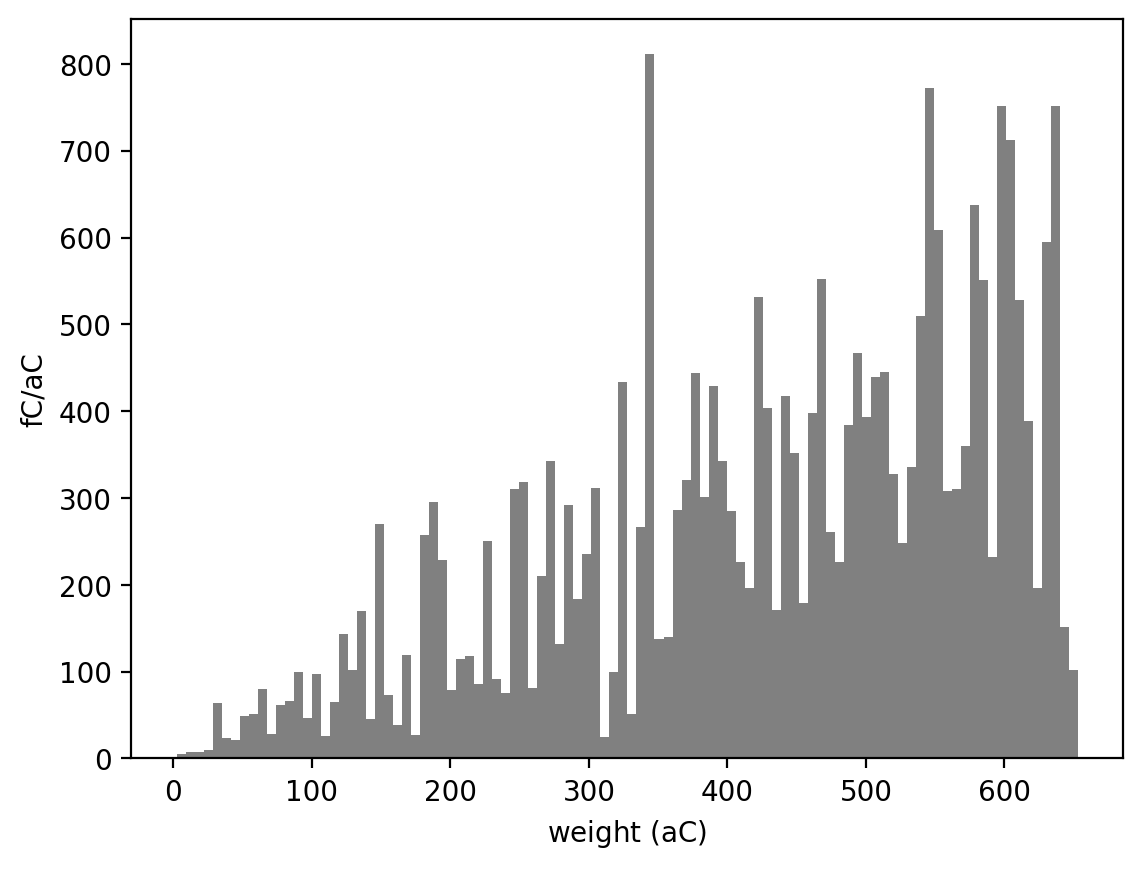

In [16]:
P2.plot('weight', bins=100)

Notice that `importdistribution` is filled in:

In [17]:
G1.input

{'main': [{'type': 'setup',
   'rootname': 'drift_test',
   'lattice': '/Users/cmayes/Code/GitHub/lume-genesis/docs/examples/genesis4/data/genesis4_drift.lat',
   'beamline': 'LAT',
   'lambda0': 1e-07,
   'gamma0': 1000,
   'delz': 0.026,
   'seed': 123456,
   'npart': 512},
  {'type': 'time', 'slen': 9.999850899316347e-05, 'sample': 1},
  {'type': 'importdistribution',
   'file': '/var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmptadbud1w/genesis4_importdistribution.h5',
   'charge': 1.6678221438112364e-10},
  {'type': 'track', 'zstop': 1},
  {'type': 'write', 'beam': 'end'}]}

# Cleanup

In [18]:
os.remove(DIST_FILE)